# Multiple Linear Regression

## Import needed packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split

In [2]:
root_path = Path(".").absolute()
data_path = root_path / "data"
data_path.mkdir(exist_ok=True)

%matplotlib inline

## Load the data

<p>The dataset you will use resides at the following URL. You can use the URL directly with the Pandas library to load the dataset.</p>

In [3]:
# url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"

file = data_path / "FuelConsumptionCo2.csv"
df = pd.read_csv(file)

In [4]:
df.sample(5)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
312,2014,DODGE,CHARGER FFV,FULL-SIZE,3.6,6,A8,E,16.8,10.3,13.9,20,222
684,2014,LINCOLN,MKZ AWD,MID-SIZE,3.7,6,AS6,X,13.1,9.3,11.4,25,262
665,2014,LEXUS,IS 350,COMPACT,3.5,6,AS8,Z,12.2,8.7,10.6,27,244
107,2014,BMW,650i xDRIVE COUPE,COMPACT,4.4,8,A8,Z,14.4,9.6,12.2,23,281
113,2014,BMW,ACTIVEHYBRID 3,COMPACT,3.0,6,A8,Z,9.2,7.1,8.3,34,191


## Understand the data

<p>You will use a fuel consumption dataset, <code>FuelConsumption.csv</code>, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. Click <a href="https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64">here</a> to see the dataset source.</p>
<p>Column Name</p>
<ul>
    <li>MODEL YEAR</li>
    <li>MAKE</li>
    <li>MODEL</li>
    <li>VEHICLE CLASS</li>
    <li>ENGINE SIZE</li>
    <li>CYLINDERS</li>
    <li>TRANSMISSION</li>
    <li>FUEL TYPE</li>
    <li>FUEL CONSUMPTION in CITY (L/100 km)</li>
    <li>FUEL CONSUMPTION in HWY (L/100 km)</li>
    <li>FUEL CONSUMPTION COMBINED (L/100 km)</li>
    <li>FUEL CONFUMPTION COMBINED MPG (MPG)</li>
    <li>CO2 EMISSIONS (g/km)</li>
</ul>
<p>Your task will be to create a simple linear regression model from one of these features to predict CO<sub>2</sub> emissions of unobserved cars based on that feature.</p>

## Explore and select features

<p>Let's select a few features to work with that might be predictive of CO<sub>2</sub> emissions.</p>

In [5]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


<p>Notice that some of the variables are not included in the description. This is because they are not numerical. In practice, you would analyze these features if required to improve the accuracy of your model. In the interest of time, you can omit this step here.</p>
<p>Notice also that <code>MODEL YEAR</code> is the same for all cars, so you can drop these variables for this modeling illustration.</p>

In [6]:
df = df.drop(["MODELYEAR", "MAKE", "MODEL", "VEHICLECLASS", "TRANSMISSION", "FUELTYPE"], axis=1)

<p>Now that you have eliminated some features, take a look at the relationships among the remaining features.</p>
<p>Analyzing a correlation matrix that displays the pairwise correlations between all features indicates the level of independence between them. It also indicates how predictive each feature is of the target.</p>
<p>You want to eliminate any strong dependencies or correlations between features by selecting the best one from each correlated group.</p>

In [7]:
df.corr()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
ENGINESIZE,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154
CYLINDERS,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685
FUELCONSUMPTION_CITY,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000


<p>Look at the bottom row, which shows the correlation between each variable and the target <code>CO2EMISSIONS</code>. Each of these shows a fairly high level of correlation, each exceeding 85% in magnitude. Thus all of these features are good candidates.</p>
<p>Next, examine the correlations of the distinct pairs. <code>ENGINESIZE</code> and <code>CYLINDERS</code> are highly correlated, but <code>ENGINESIZE</code> is more correlated with the target, so we can drop <code>CYLINDERS</code>.</p>
<p>Similarly, each of the four fuel economy variables is highly correlated with each other. Since <code>FUELCONSUMPTION_COMB_MPG</code> is the most correlated with the target, you can drop the others: <code>FUELCONSUMPTION_CITY</code>, <code>FUELCONSUMPTION_HWY</code> and <code>FUELCONSUMPTION_COMB</code>.</p>
<p>Notice that <code>FUELCONSUMPTION_COMB</code> and <code>FUELCONSUMPTION_COMB_MPG</code> are not perfectly correlated. They should be, though, because they measure the same property in different units. In practice, you would investigate why this is the case. You might find out that some or all of the data is not useable as is.</p>

In [8]:
df = df.drop(["CYLINDERS", "FUELCONSUMPTION_CITY", "FUELCONSUMPTION_HWY", "FUELCONSUMPTION_COMB"], axis=1)
df.head(9)

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244
5,3.5,28,230
6,3.5,28,232
7,3.7,25,255
8,3.7,24,267


<p>To help with selecting predictive features that are not redundant, consider the following scatter matrix, which shows the scatter plots for each pair of input features. The diagonal of the matrix shows each feature's histogram.</p>

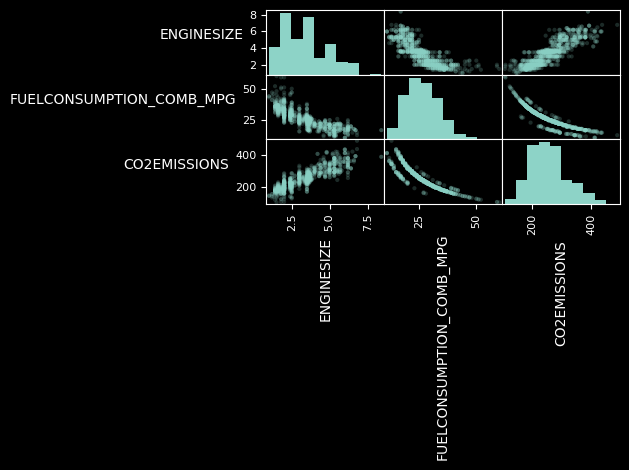

In [9]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)

<p>As you can see, the relationship between <code>FUELCONSUMPTION_COMB_MPG</code> and <code>CO2EMISSIONS</code> is non-linear. In addition, you can clearly see three different curves. This suggests exploring the categorical variables to see if they are able to explain these differences. Let's leave this as an exercise for you to explore deeper. Regarding the non-linearity, you will handle this in the next lab. For now, let's just consider through modeling whether fuel economy explains some of the variances in the target as is.</p>

## Extract the input features and labels from the dataset

<p>Extract the required columns and convert the resulting dataframes to NumPy arrays.</p>

In [10]:
X = df.iloc[:, [0, 1]].to_numpy()
Y = df.iloc[:, [2]].to_numpy()

## Preprocess selected features

<p>You should standardize your input features so the model doesn't inadvertently favor any feature due to its magnitude. The typical way to do this is to subtract the mean and divide by the standard deviation. Scikit-learn can do this for you.</p>

In [11]:
std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

<p>In practice, if you want to properly evaluate your model, you should definitely not apply such operations to the entire dataset but to the train and test data separately. There's more to it than that. You will dive deeper into this and other advanced evaluation pitfalls later in the course.</p>

In [12]:
pd.DataFrame(X_std).describe().round(2)

,0,1
count,1067.00,1067.00
mean,0.00,-0.00
std,1.00,1.00
min,-1.66,-2.07
25%,-0.95,-0.73
50%,0.04,-0.06
75%,0.67,0.61
max,3.57,4.50


<p>As you can see, a standardized variable has zero mean and a standard deviation of one.</p>

## Create train and test datasets

<p>Randomly split your data into train and test sets, using 80% of the dataset for training and reserving the remaining 20% for testing.</p>

In [13]:
split_data: list[np.ndarray] = train_test_split(X_std, Y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = split_data

## Build a multiple linear regression model

<p>Multiple and simple linear regression models can be implemented with exactly the same scikit-learn tools.</p>

In [14]:
regressor = linear_model.LinearRegression()
regressor.fit(x_train, y_train)

coef_: np.ndarray = regressor.coef_
intercept_: np.ndarray = regressor.intercept_

print(f"Coefficients: {coef_}")
print(f"Intercept: {intercept_}")

Coefficients: [[ 25.27339614 -37.4381472 ]]
Intercept: [256.29072488]


<p>The Coefficients and Intercept parameters define the best-fit hyperplane to the data. Since there are only two variables, hence two parameters, the hyperplane is a plane. But this best-fit plane will look different in the original, unstandardized feature space.</p>
<p>You can transform your model's parameters back to the original space prior to standardization as follows. This gives you a proper sense of what they mean in terms of your original input features. Without these adjustments, the model's outputs would be tied to an abstract, transformed space that doesn't align with the actual independent variables and the real-world problem you're solving.</p>

In [15]:
means_: np.ndarray = std_scaler.mean_
std_devs_: np.ndarray = np.sqrt(std_scaler.var_)

coef_original = coef_ / std_devs_
intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)

print(f"Coefficients: {coef_original}")
print(f"Intercept: {intercept_original}")

Coefficients: [[17.8581369  -5.01502179]]
Intercept: [329.1363967]


<p>You would expect that for the limiting case of zero <code>ENGINESIZE</code> and zero <code>FUELCONSUMPTION_COMB_MPG</code>, the resulting CO<sub>2</sub> emissions should also be zero. This is inconsistent with the best-fit hyperplane, which has a non-zero intercept of 329 g/km. The answer must be that the target variable does not have a very strong linear relationship to the dependent variables, and/or the data has outliers that are biasing the result. Outliers can be handled in preprocessing, or as you will learn about later in the course, by using regularization techniques. One or more of the variables might have a non-linear relationship to the target. Or there may still be some colinearity amongst the input variables.</p>

## Visualize model outputs

<p>You can visualize the goodness-of-fit of the model to the training data by plotting the fitted plane over the data.</p>

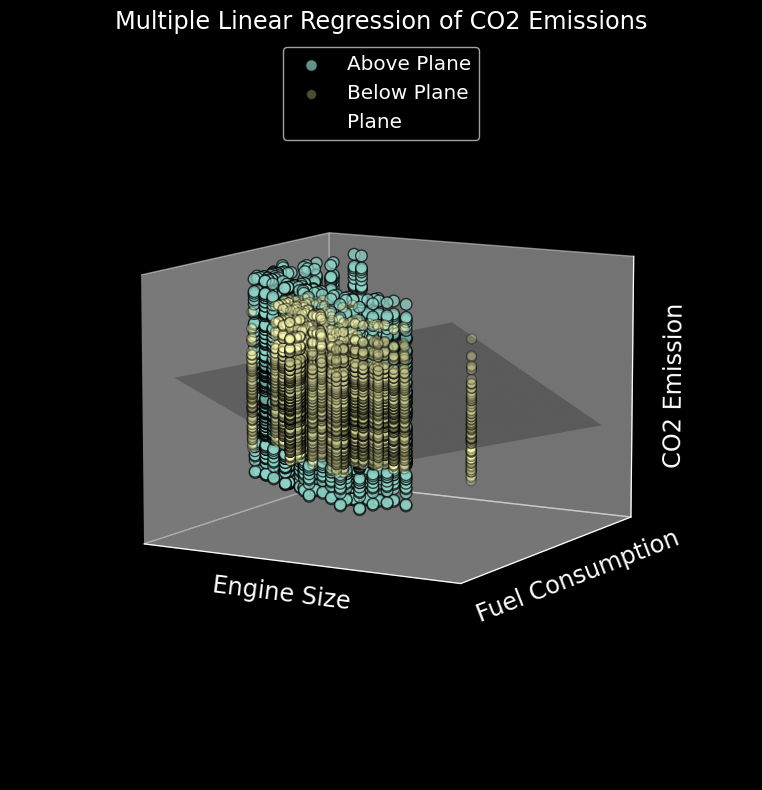

In [16]:
# ensure X1, X2 and y_test have compatible shapes for 3D plotting
X1 = x_test[:, 0] if x_test.ndim > 1 else x_test
X2 = x_test[:, 1] if x_test.ndim > 1 else np.zeros_like(X1)

# create a mesh grid for plotting the regression plane
X1_surf, X2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100), np.linspace(X2.min(), X2.max(), 100))
Y_surf: np.ndarray = intercept_ + coef_[0, 0] * X1_surf + coef_[0, 1] * X2_surf

# predict y values using trained regression model to compare with actual y_test for above/below plane colors
Y_pred: np.ndarray = regressor.predict(x_test.reshape(-1, 1)) if x_test.ndim == 1 else regressor.predict(x_test)
above_plane = y_test >= Y_pred
above_plane = above_plane[:, 0]

below_plane = y_test < Y_pred
below_plane = below_plane[:, 0]

# begin plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection="3d")

# plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane], label="Above Plane", s=70, alpha=0.7, ec="k")
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane], label="Below Plane", s=50, alpha=0.3, ec="k")

# plot the regression plane
ax.plot_surface(X1_surf, X2_surf, Y_surf, color="k", alpha=0.21, label="Plane")

# set view and labels
ax.view_init(elev=10)
ax.legend(fontsize="x-large", loc="upper center")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel("Engine Size", fontsize="xx-large")
ax.set_ylabel("Fuel Consumption", fontsize="xx-large")
ax.set_zlabel("CO2 Emission", fontsize="xx-large")
ax.set_title("Multiple Linear Regression of CO2 Emissions", fontsize="xx-large")
plt.tight_layout()

<p>Instead of making a 3D plot, which is difficult to interpret, you can look at vertical slices of the 3D plot by plotting each variable separately as a best-fit line using the corresponding regression parameters.</p>

Text(0, 0.5, 'CO2 Emission')

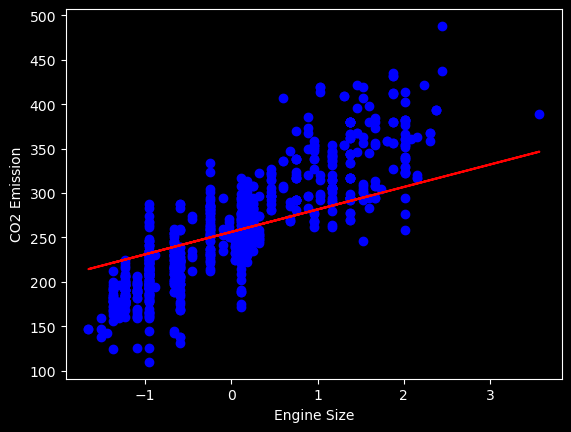

In [17]:
plt.scatter(x_train[:, 0], y_train, color="blue")
plt.plot(x_train[:, 0], coef_[0, 0] * x_train[:, 0] + intercept_[0], "-r")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")

Text(0, 0.5, 'CO2 Emission')

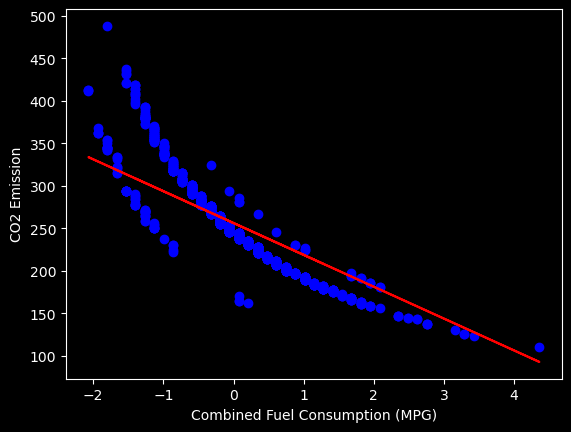

In [18]:
plt.scatter(x_train[:, 1], y_train, color="blue")
plt.plot(x_train[:, 1], coef_[0, 1] * x_train[:, 1] + intercept_[0], "-r")
plt.xlabel("Combined Fuel Consumption (MPG)")
plt.ylabel("CO2 Emission")

<p>Evidently, the solution is incredibly poor because the model is trying to fit a plane to a non-planar surface.</p>

## Exercise

<p>1. Determine and print the parameters for the best-fit linear regression line for CO<sub>2</sub> emission with respect to engine size.</p>

In [19]:
x_train_1 = x_train[:, 0]
regressor_1 = linear_model.LinearRegression()
regressor_1.fit(x_train_1.reshape(-1, 1), y_train)
coef_1 = regressor_1.coef_
intercept_1 = regressor_1.intercept_

print(f"Coefficients: {coef_1}")
print(f"Intercept: {intercept_1}")

Coefficients: [[55.18408797]]
Intercept: [256.77183014]


<p>2. Produce a scatterplot of CO<sub>2</sub> emission against <code>ENGINESIZE</code> and include the best-fit regression line to the training data.</p>

Text(0, 0.5, 'CO2 Emission')

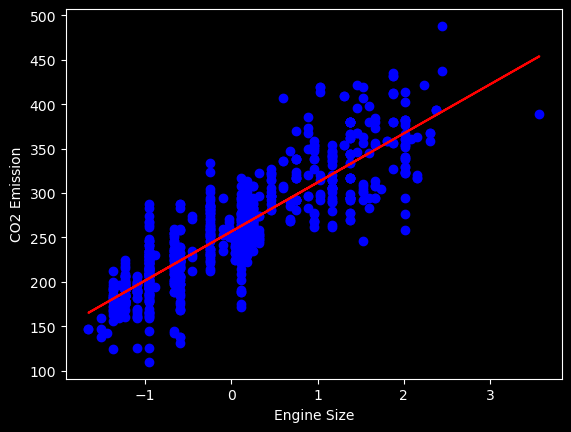

In [20]:
plt.scatter(x_train_1, y_train, color="blue")
plt.plot(x_train_1, coef_1[0] * x_train_1 + intercept_1, "-r")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")

<p>Evidently, this simple linear regression model provides a much better fit of CO<sub>2</sub> emissions on the training data than the multiple regression model did. Let's see what its performance is on the test data.</p>

<p>3. Generate the same scatter plot and best-fit regression line, but now base the result on the test data set. Consider how the test result compares to the training result.</p>

Text(0, 0.5, 'CO2 Emission')

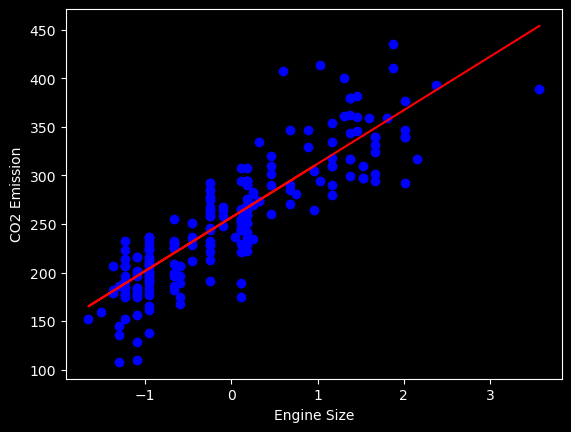

In [21]:
x_test_1 = x_test[:, 0]
plt.scatter(x_test_1, y_test, color="blue")
plt.plot(x_test_1, coef_1[0] * x_test_1 + intercept_1, "-r")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")

<p>4. Repeat the same modeling but use <code>FUELCONSUMPTION_COMB_MPG</code> as the independent variable instead. Display the model coefficients including the intercept.</p>

In [22]:
x_train_2 = x_train[:, 1]
regressor_2 = linear_model.LinearRegression()
regressor_2.fit(x_train_2.reshape(-1, 1), y_train)
coef_2 = regressor_2.coef_
intercept_2 = regressor_2.intercept_

print(f"Coefficients: {coef_2}")
print(f"Intercept: {intercept_2}")

Coefficients: [[-58.51827989]]
Intercept: [256.09392179]


<p>5. Generate a scatter plot showing the results as before on the test data. Consider well the model fits, and what you might be able to do to improve it. We will revisit this later in the course.</p>

Text(0, 0.5, 'CO2 Emission')

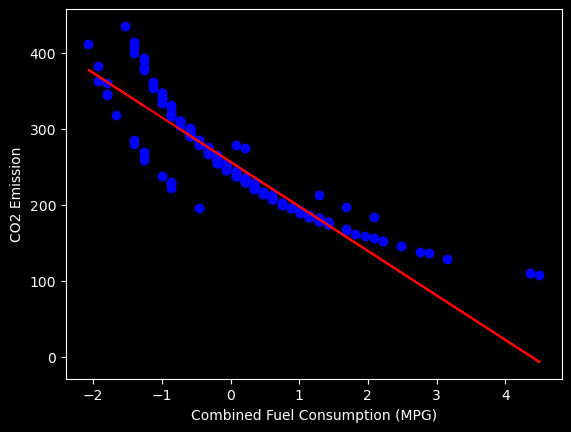

In [23]:
x_test_2 = x_test[:, 1]
plt.scatter(x_test_2, y_test, color="blue")
plt.plot(x_test_2, coef_2[0] * x_test_2 + intercept_2, "-r")
plt.xlabel("Combined Fuel Consumption (MPG)")
plt.ylabel("CO2 Emission")

****
This is the end of the file.
****